In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import pyglstudy as gl
from pyglstudy.group_lasso import *
from pyglstudy.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

In [3]:
def analyze_base(out):
    diag = out['diagnostic']

    if out['error'] != '':
        logging.warning(out['error'])

    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")
    
    gl_diag = diag['time_group_lasso']
    time_strong = [np.sum(d['time_strong_cd']) for d in gl_diag]
    time_active = [np.sum(d['time_active_cd']) for d in gl_diag]
    logging.debug(f"Time Strong Total:  {np.sum(time_strong)}")
    logging.debug(f"Time Active Total:  {np.sum(time_active)}")

    logging.debug(f"Number of lambdas:  {len(out['lmdas'])}")

def analyze_cov(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Loop Number")
            ax.set_ylabel("Time (s)")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    axes[0].plot(diag['n_cds'], marker='.')
    axes[0].set_title("Number of CDs")
    axes[0].set_xlabel("Basil Iteration")
    axes[0].set_ylabel("Number of CDs")
    axes[1].plot(-np.log(out['lmdas']), out['rsqs'], marker='.')
    axes[1].set_title("$R^2$")
    axes[1].set_xlabel("$-\\log(\\lambda)$")
    axes[1].set_ylabel("$R^2$")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    active_count = [out['betas'][:, j].count_nonzero() for j in range(out['betas'].shape[-1])]
    axes[0].plot(active_count, marker='.')
    axes[0].set_title("Active Count")
    axes[0].set_xlabel("$\\lambda$ index")
    axes[0].set_ylabel("Active count")

    axes[1].plot(out['diagnostic']['strong_sizes_total'], marker='.')
    axes[1].set_title("Strong Count")
    axes[1].set_xlabel("$\\lambda$ index")
    axes[1].set_ylabel("Strong count")
    plt.show()
    
    _, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
    for j in tqdm(range(out['betas'].shape[0])):
        beta_j = out['betas'][j]
        if beta_j.count_nonzero() > 0:
            axes.plot(-np.log(out['lmdas']), beta_j.todense().reshape((-1,1)))
    axes.set_title('Non-zero $\\beta$ Profile')
    axes.set_xlabel('$-\log(\lambda)$')
    axes.set_ylabel('$\\beta$')
    plt.show()


In [7]:
n = 100
p = 100000
n_groups = int(p/100)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=0.1, svd_transform=False, group_split_type="random",
).values()

In [21]:
# cov
#out_cov = group_basil(X, y, groups, group_sizes, method='cov', max_n_cds=int(1e5))
#diag_cov = out_cov['diagnostic']

In [10]:
# naive
out_naive = group_basil(X, y, groups, group_sizes, method='naive', max_n_cds=int(1e5), n_lambdas_iter=5, use_strong_rule=True)
diag_naive = out_naive['diagnostic']

DEBUG:root:Time Init:          0.0018520420000000001
DEBUG:root:Time Init Fit:      0.001575833
DEBUG:root:Time Screen:        0.000512126
DEBUG:root:Time Fit:           0.993198958
DEBUG:root:Time KKT:           0.041887124000000005
DEBUG:root:Time Transform:     0.146971458
DEBUG:root:Time Untransform:   0.000132
DEBUG:root:Time Strong Total:  0.7207908449999999
DEBUG:root:Time Active Total:  0.265293213
DEBUG:root:Number of lambdas:  51
100%|██████████| 11/11 [00:00<00:00, 3667.81it/s]


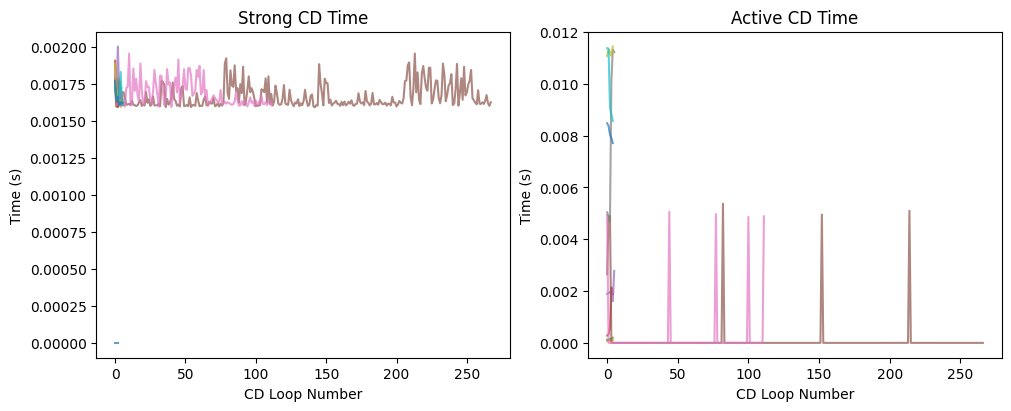

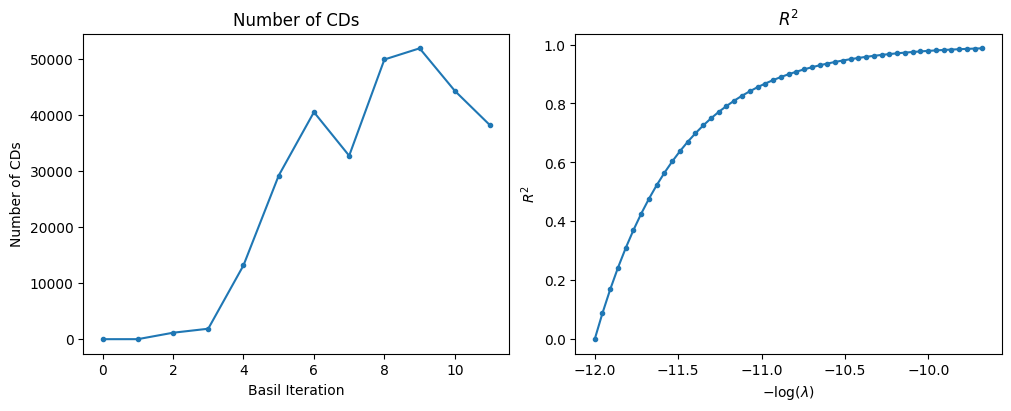

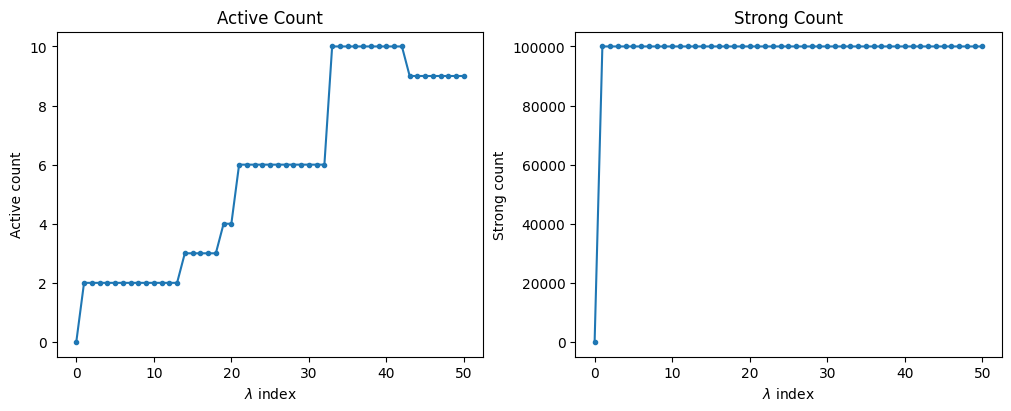

100%|██████████| 100000/100000 [00:03<00:00, 32264.82it/s]


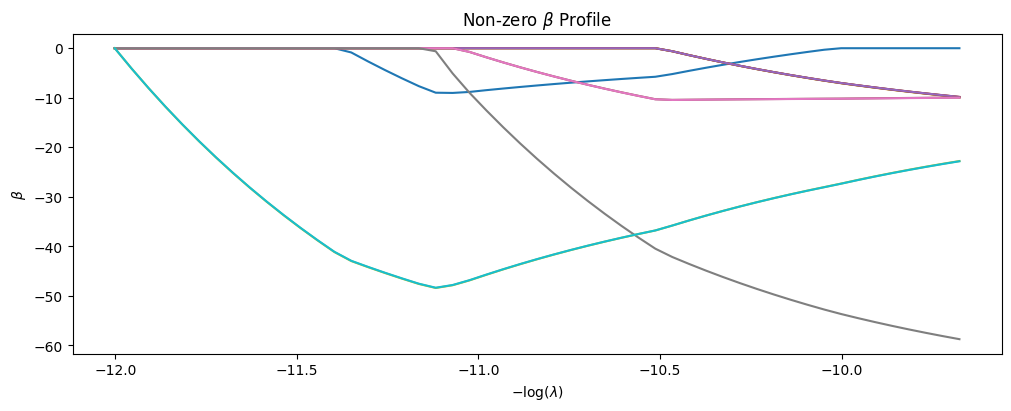

In [11]:
analyze_naive(out_naive)

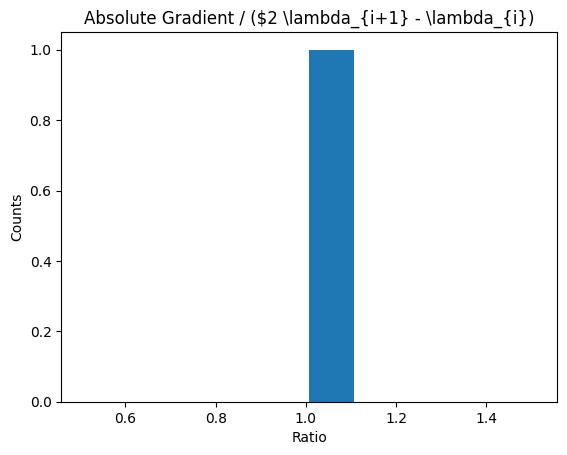

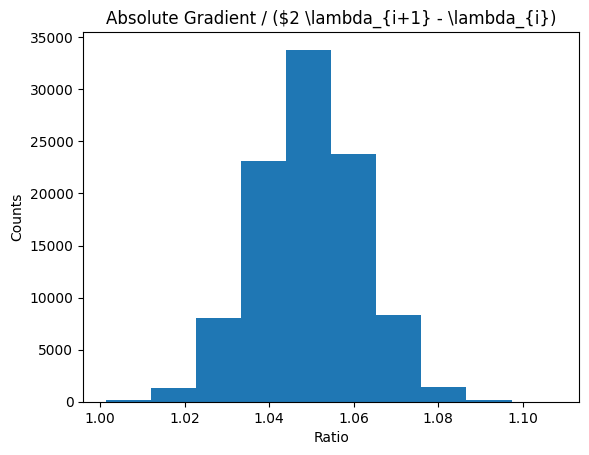

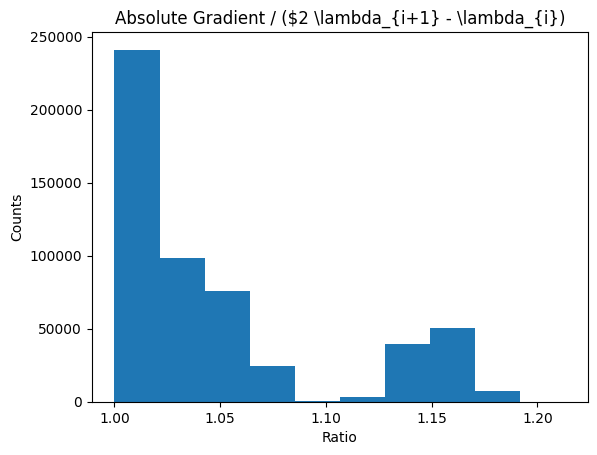

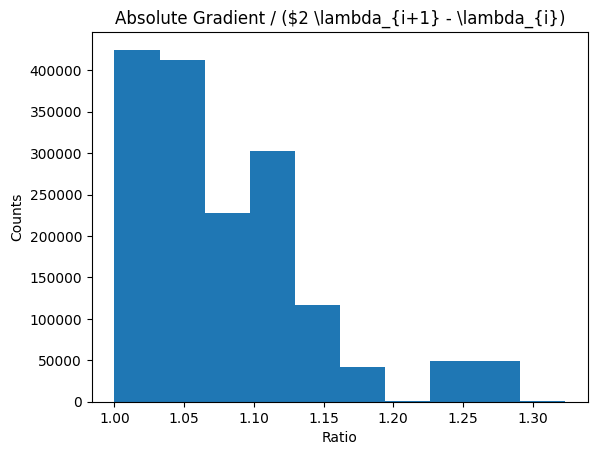

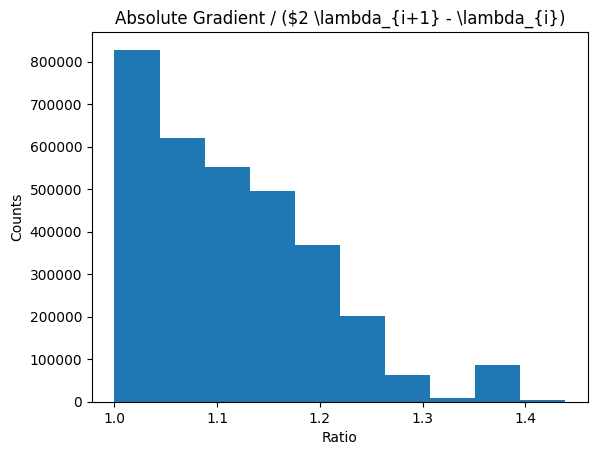

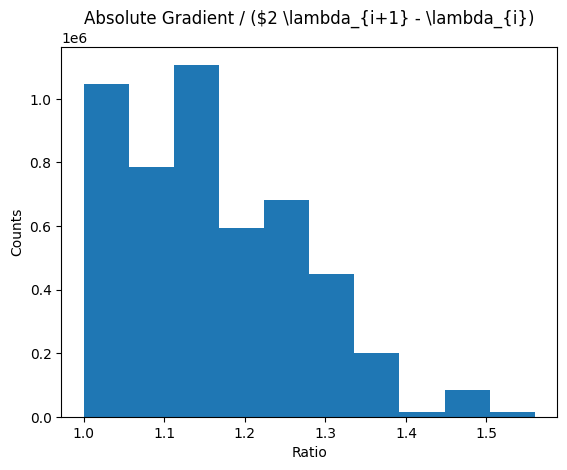

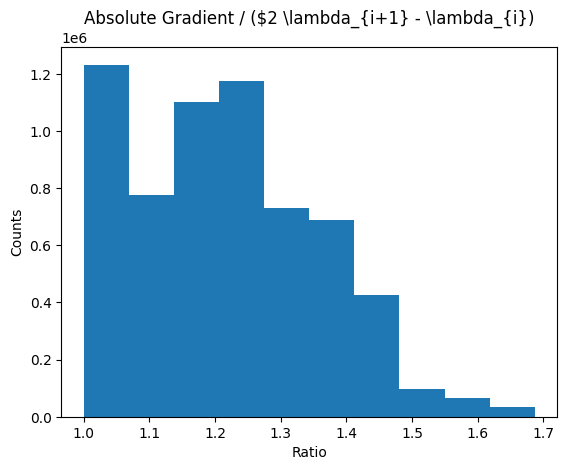

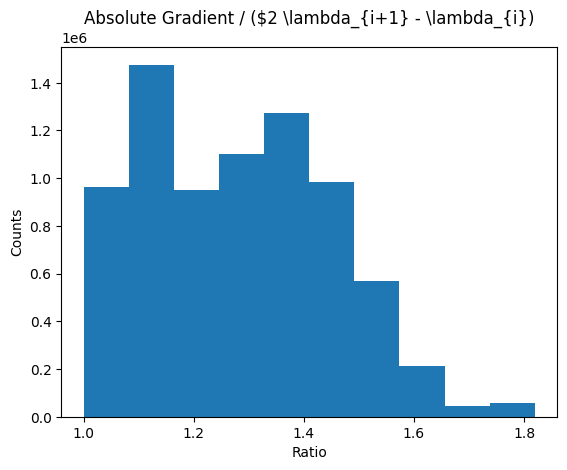

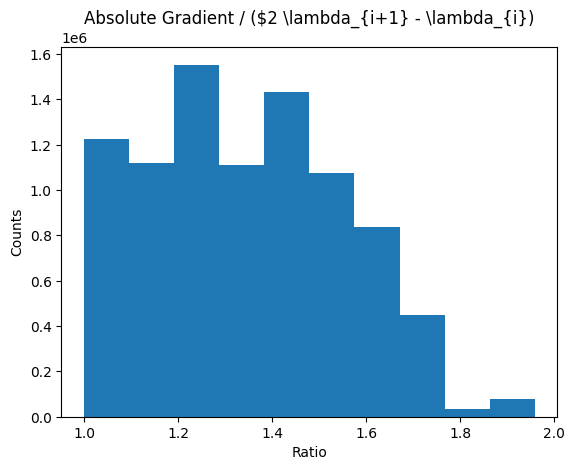

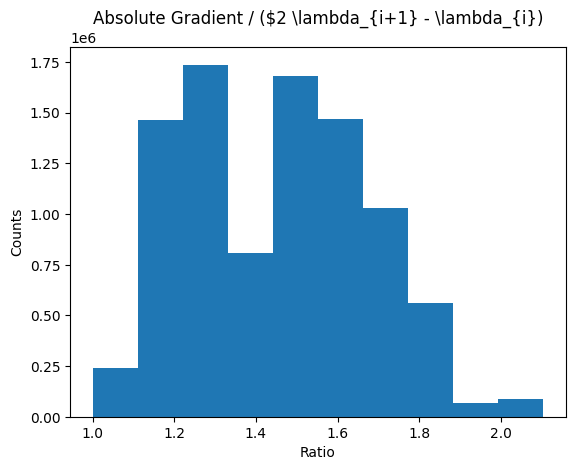

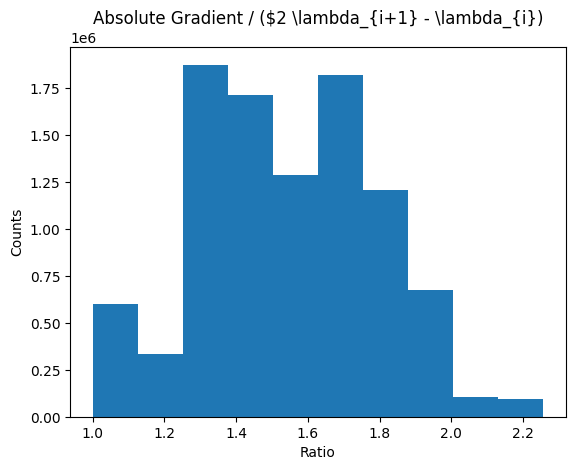

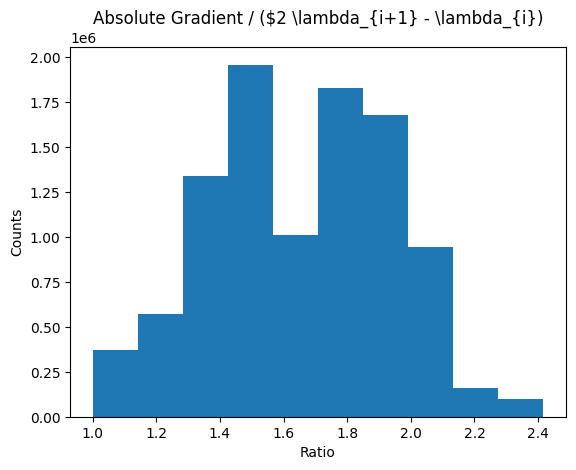

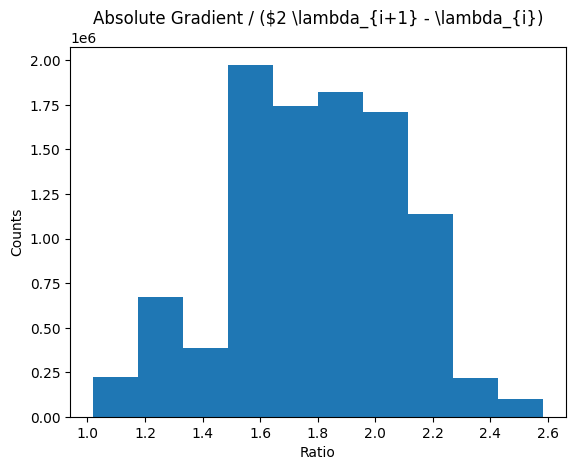

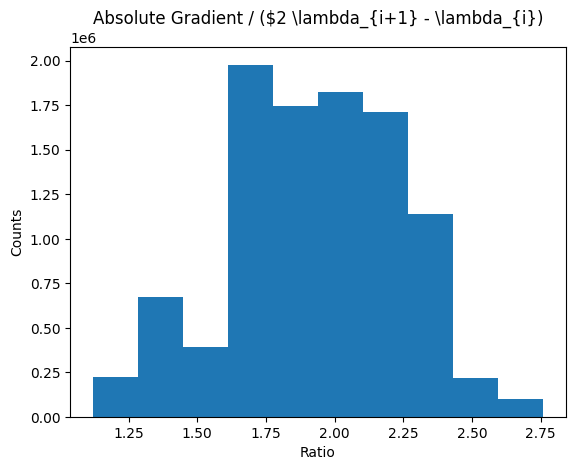

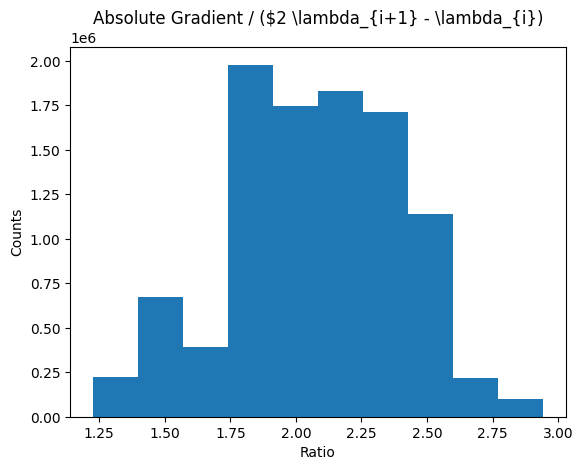

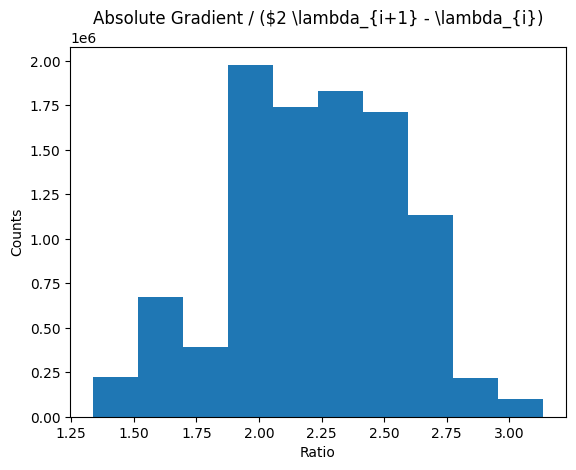

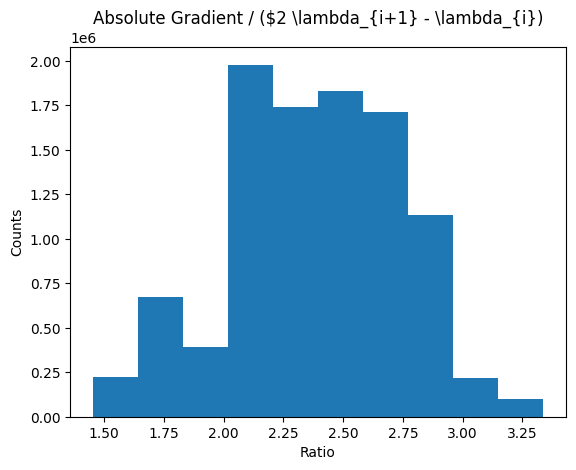

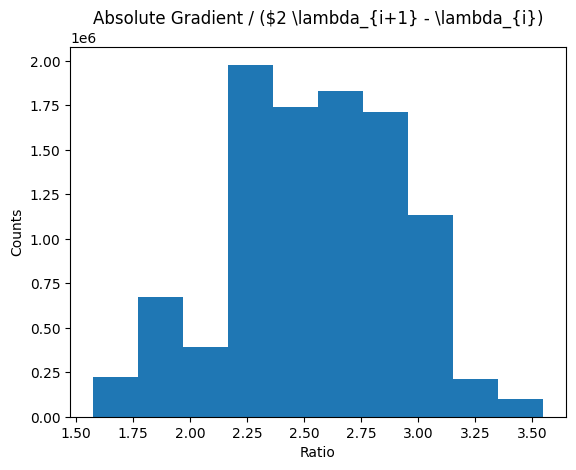

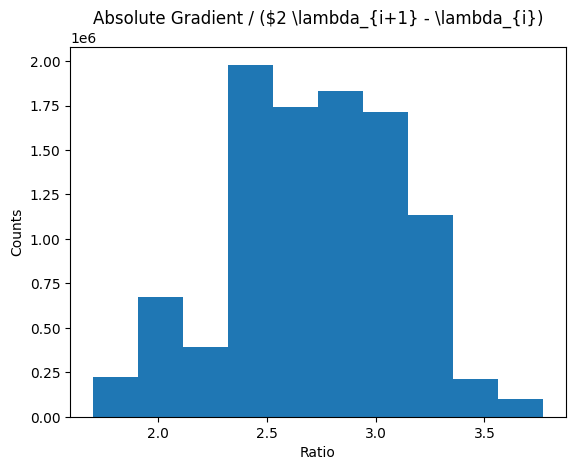

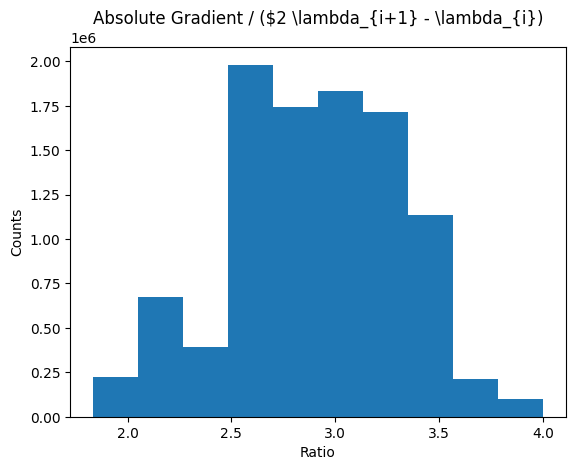

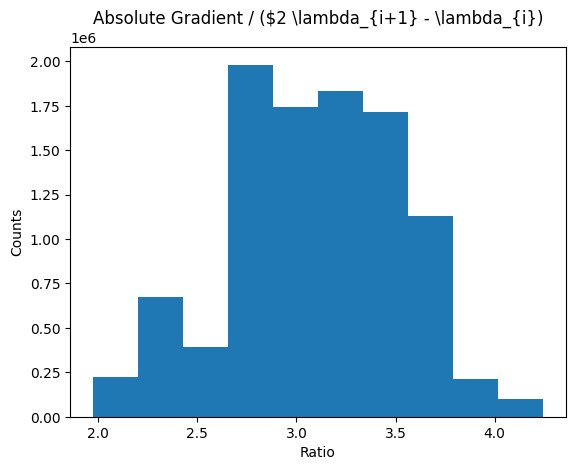

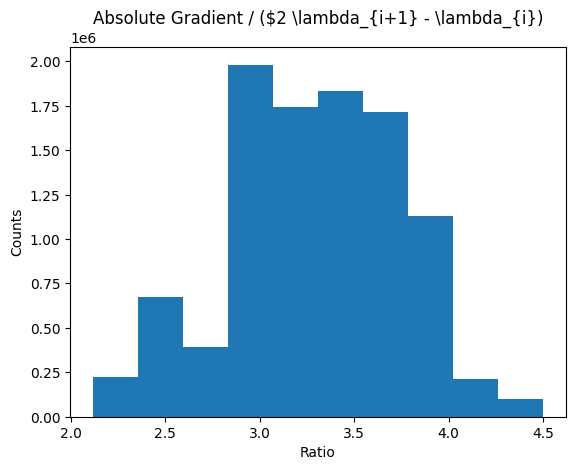

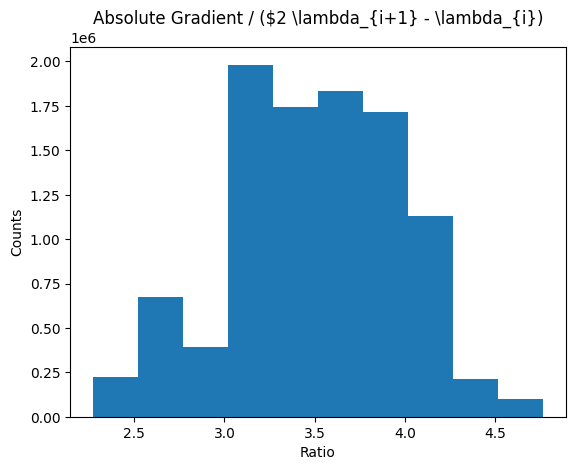

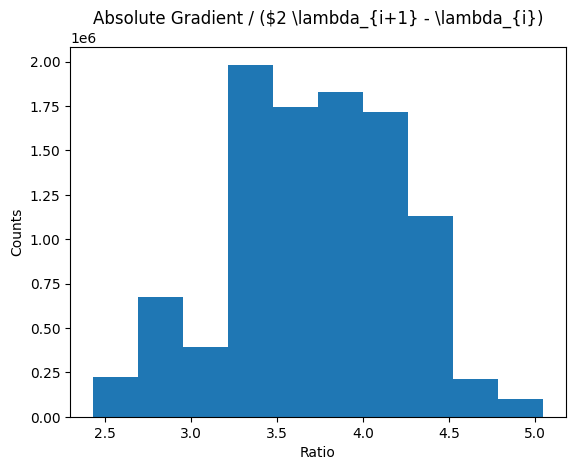

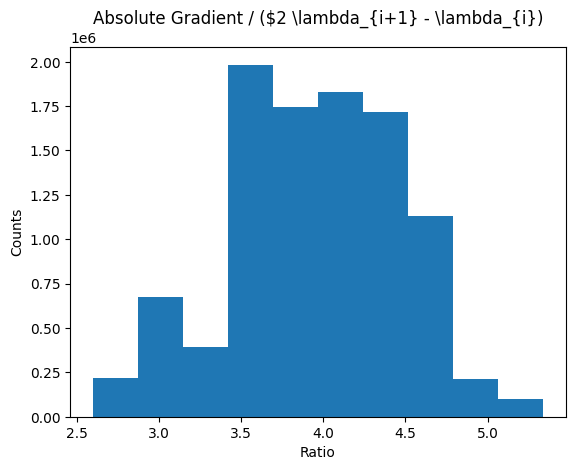

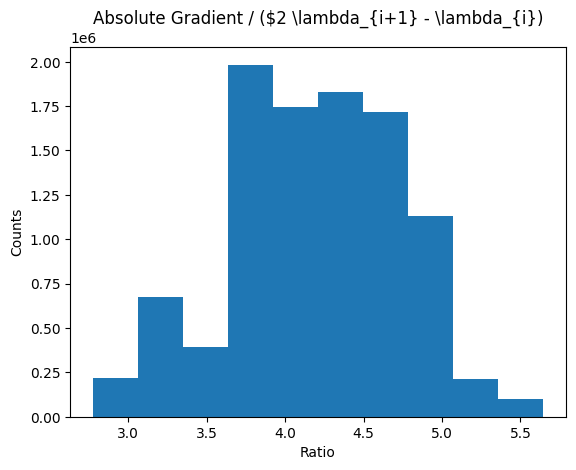

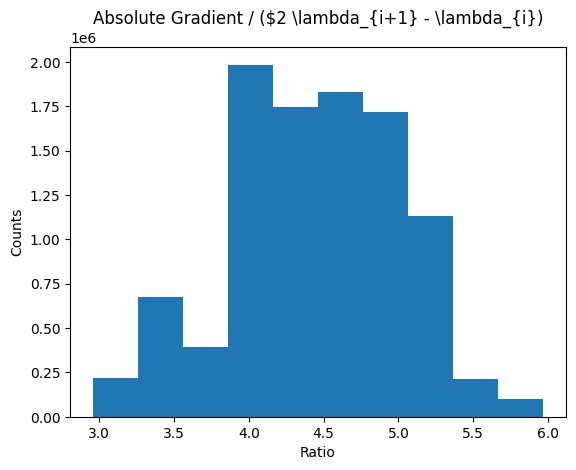

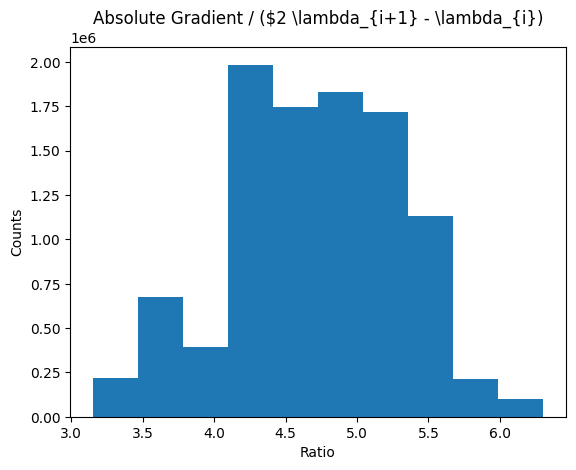

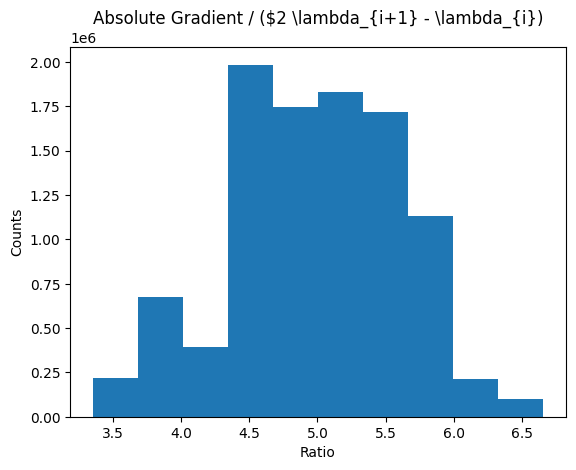

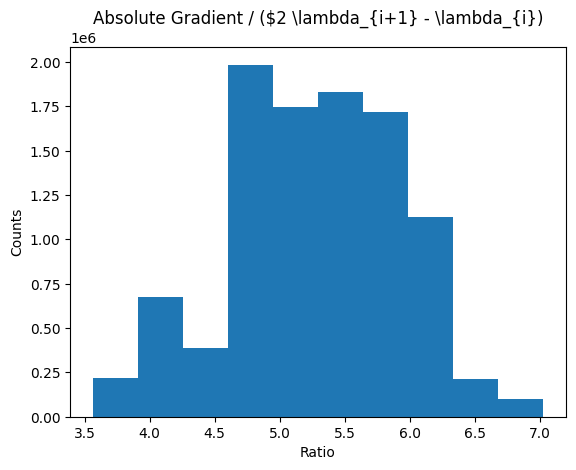

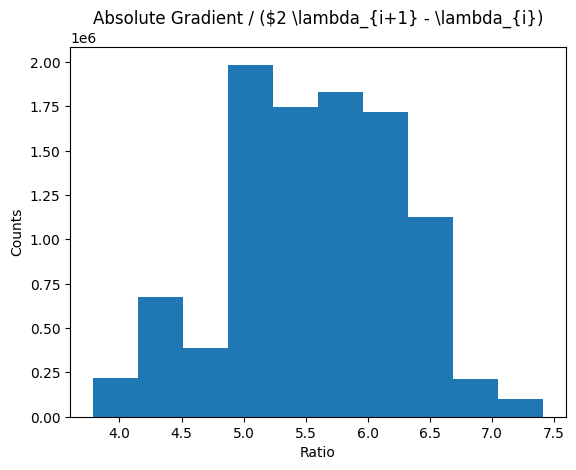

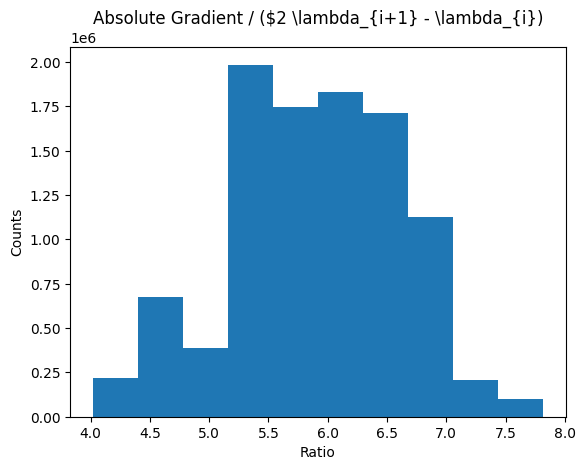

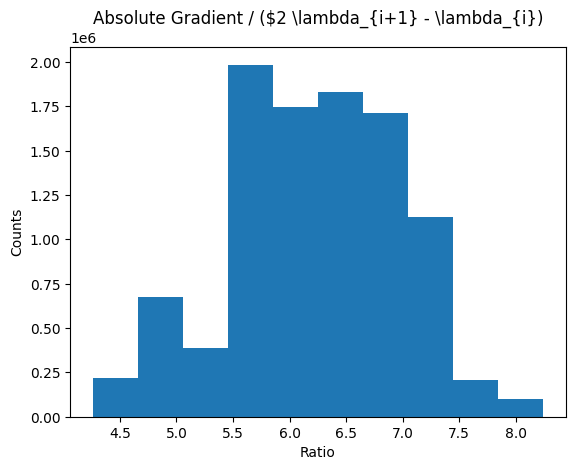

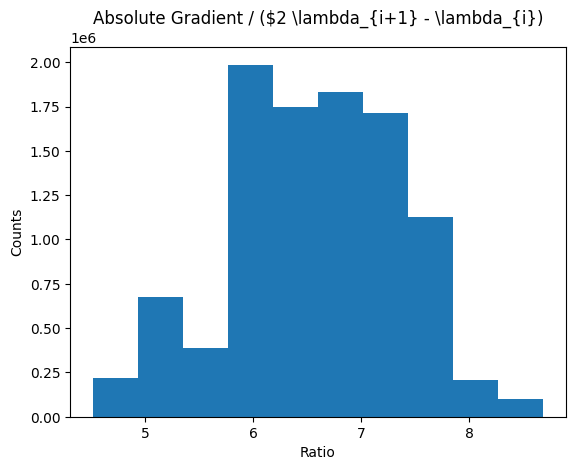

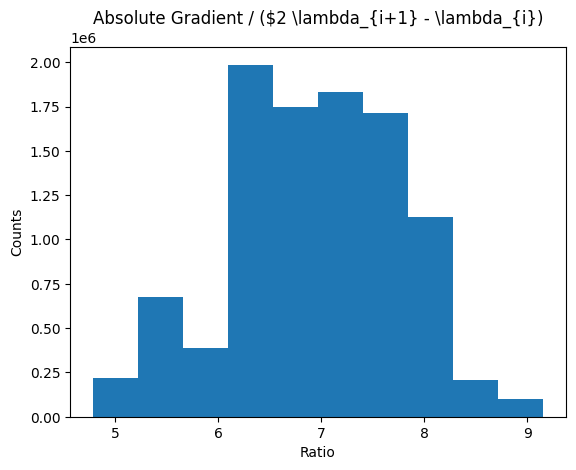

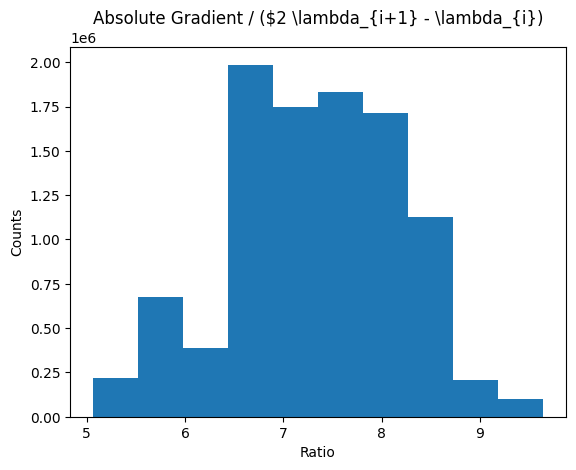

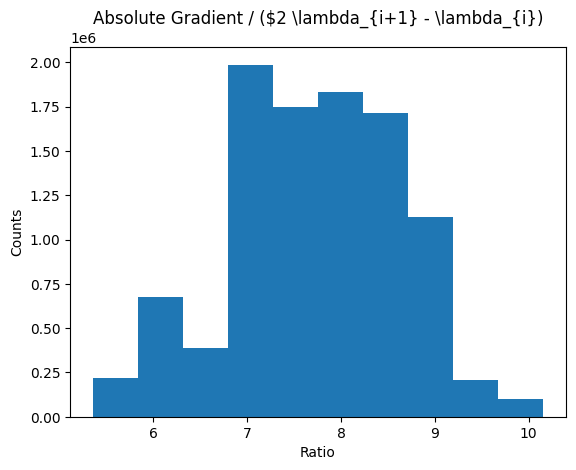

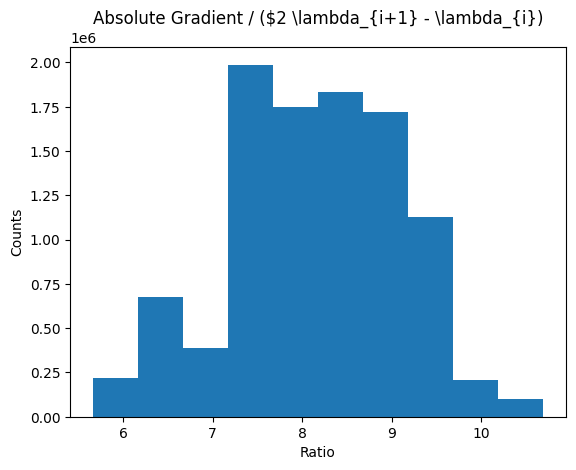

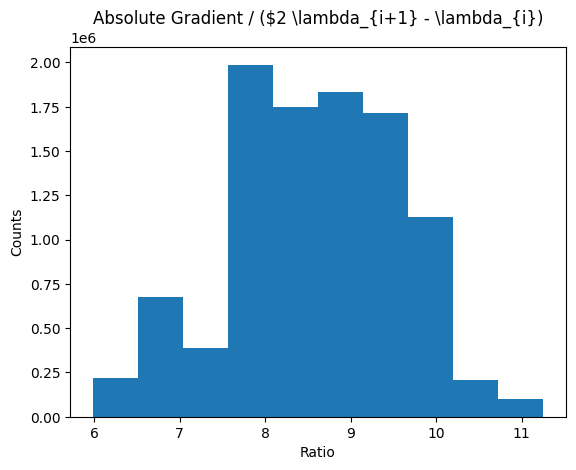

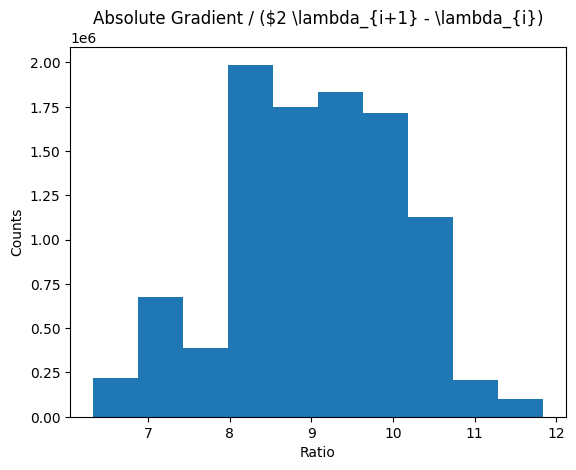

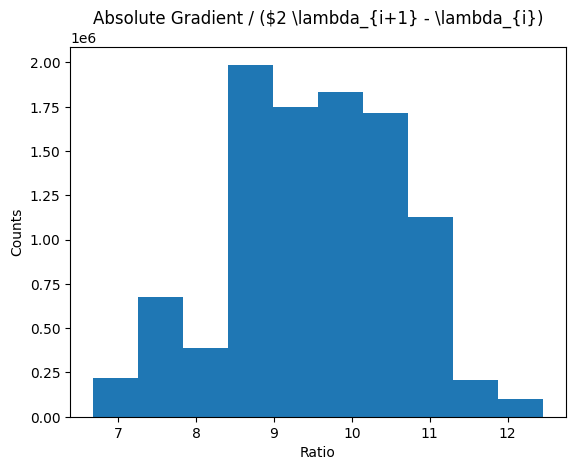

In [19]:
for i in range(out_naive['betas'].shape[-1]-1):
    b = out_naive['betas'][:, i]
    abs_grad = np.abs(X.T @ (y - X @ b)) / (2 * out_naive['lmdas'][i+1] - out_naive['lmdas'][i])
    abs_grad = abs_grad[abs_grad >= 1]
    if len(abs_grad) == 0: continue
    plt.hist(abs_grad)
    plt.title("Absolute Gradient / ($2 \\lambda_{i+1} - \\lambda_{i}$)")
    plt.ylabel("Counts")
    plt.xlabel("Ratio")
    plt.show()

In [ ]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)
    regul = 0
    for i in range(len(groups)):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm2 = cp.norm2(beta[gb:ge])
        regul += penalty[i] * (alpha * bi_norm2 + (1-alpha) / 2 * cp.sum_squares(beta[gb:ge]))
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * regul)
    prob = cp.Problem(objective)
    result = prob.solve()
    return beta.value 


In [ ]:
lmdas = np.array(out['lmdas'])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=1, penalty=np.sqrt(group_sizes), lmda=lmdas[i])

In [ ]:
for j in range(cvxpy_betas.shape[0]):
    if j % (10) == 0:
        plt.plot(-np.log(out['lmdas']), cvxpy_betas[j])
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()